In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet

# Plant Pathology 2020 - FGVC7

Here are some basic configurations:
* With the option `LOCAL = True`, we use `efficientnet-b5` as the backbone running on `CPU` to train model with `batch_size = 1` and `epoch_time = 1` to pre-validate the code.
* With the option `LOCAL = False`, we use `efficientnet-b5` as the backbone running on `GPU` to train model with `batch_size = 10` and `epoch_time = 20` to make accurate predictions.

Once the `DEBUG` option is on, nothing will be stored into the file system.

In [2]:
LOCAL = True
DEBUG = False

DEVICE = torch.device('cpu' if LOCAL else 'cuda')
MODEL = 'efficientnet-b5'

BATCH_SIZE = 1 if LOCAL else 10
EPOCH_TIME = 1 if LOCAL else 20

INPUT_DIR = './dataset' if LOCAL else '/kaggle/input/plant-pathology-2020-fgvc7'
INPUT_SIZE = EfficientNet.get_image_size(MODEL)

## Data Preprocessing

`80%` of the training set will be used for `training`, and the other `20%` will be used for `validation`.

Besides, we'll use these randomly ordered methods to augment training sets:

* ColorJitter
* RandomGreyscale
* RandomHorizontalFlip
* RandomVerticalFlip
* RandomRotation
* RandomPerspective

With the option `DEBUG = True`, only the first `5 * BATCH_SIZE` rows of data will be loaded.

In [3]:
from torch.utils.data import Dataset, random_split
from torchvision.transforms import RandomOrder, ColorJitter, RandomHorizontalFlip, RandomVerticalFlip, RandomGrayscale, RandomPerspective, RandomRotation
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from PIL import Image

class PlantDataset(Dataset):
    
    def __init__(self, train = True):
        
        self.train = train
        
        self.dataset = pd.read_csv('{}/{}.csv'.format(INPUT_DIR, ('train' if train else 'test')))
        
        if DEBUG:
            self.dataset = self.dataset.head(n = 5 * BATCH_SIZE)
        
        if self.train:
            
            self.augment = RandomOrder([
                ColorJitter(brightness = 0.5, contrast = 0.5, saturation = 0.5, hue = 0.1),
                RandomGrayscale(),
                RandomHorizontalFlip(),
                RandomVerticalFlip(),
                RandomRotation((-180, +180)),
                RandomPerspective(),
            ])
            
        self.transform = Compose([
            Resize((INPUT_SIZE, INPUT_SIZE)),
            ToTensor(),
            Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        
    def __len__(self):
        
        return self.dataset.shape[0]
    
    def __getitem__(self, index):
        
        image = Image.open('{}/images/{}.jpg'.format(INPUT_DIR, self.dataset.loc[index, 'image_id']))
        
        if self.train:
            image = self.augment(image)
        
        image = self.transform(image)
        
        if self.train:
            
            label = np.argmax(self.dataset.loc[index, ['healthy', 'multiple_diseases', 'rust', 'scab']].values)
            
            return image, label
        else:
            return image, index

train_raw = PlantDataset(train = True)
test_raw = PlantDataset(train = False)

train_set, test_set = random_split(train_raw, [int(0.8 * len(train_raw)), len(train_raw) - int(0.8 * len(train_raw))])

## Model Validation

We use `20%` of the training set to validate the accuracy of the model.

In [4]:
def validate(model, loader, pbar = None):

    if pbar is None:
        with tqdm(total = len(loader) * BATCH_SIZE) as pbar:
            return validate(model, loader, pbar)
        
    correct, total = 0, 0
            
    with torch.no_grad():
        for images, labels in loader:

            outputs = model(images.to(DEVICE).float())

            _, predictions = torch.max(outputs.data, 1)

            predictions = predictions.cpu().numpy()

            for idx, prediction in enumerate(predictions):

                if prediction == labels[idx]:
                    correct = correct + 1

                total = total + 1

            pbar.update(BATCH_SIZE)
                
    return correct / total

## Model Training

The training process will iterate for `EPOCH` times, every time we use `80%` of the training data to train the model and use the other `20%` to validate the accuracy. Before the training process, the program will try to load the previous checkpoint if it exists; and after the training process, it will save a new checkpoint.

* With the option `LOCAL = True`, the program won't train again if there is a previous checkpoint to save time.
* With the option `DEBUG = True`, no checkpoints will be stored.

In [5]:
!mkdir -p ./checkpoints

In [6]:
import os
import json
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

def train(model, train_set, test_set, label = None, ax = None):

    if (label is not None) and os.path.isfile('./checkpoints/{}.ckpt'.format(label)):
        model.load_state_dict(torch.load('./checkpoints/{}.ckpt'.format(label)))
    
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters())
    
    scores, losses = [], []
    
    if (label is not None) and os.path.isfile('./checkpoints/{}.scores.json'.format(label)):
        with open('./checkpoints/{}.scores.json'.format(label), 'r') as file:
            scores = json.load(file)
            
    if (label is not None) and os.path.isfile('./checkpoints/{}.losses.json'.format(label)):
        with open('./checkpoints/{}.losses.json'.format(label), 'r') as file:
            losses = json.load(file)
    
    train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)
    test_loader = DataLoader(test_set, batch_size = BATCH_SIZE)
    
    if (not LOCAL) or (len(scores) == 0 and len(scores) == 0):
    
        with tqdm(total = EPOCH_TIME * (len(train_loader) + len(test_loader)) * BATCH_SIZE) as pbar:
            for epoch in range(0, EPOCH_TIME):

                for idx, (images, labels) in enumerate(train_loader):

                    outputs = model(images.to(DEVICE).float())
                    loss = criterion(outputs, labels.to(DEVICE))

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    pbar.update(BATCH_SIZE)

                loss = loss.cpu().item()
                score = validate(model, test_loader, pbar)

                pbar.set_postfix(loss = loss, score = score)

                losses.append(loss)
                scores.append(score)
    
    if (not DEBUG) and (label is not None):
        
        torch.save(model.state_dict(),'./checkpoints/{}.ckpt'.format(label))

        with open('./checkpoints/{}.scores.json'.format(label), 'w') as file:
            json.dump(scores, file)
            
        with open('./checkpoints/{}.losses.json'.format(label), 'w') as file:
            json.dump(losses, file)
        
    if ax is not None:
        
        ax.plot(scores, label = 'score')
        ax.plot(losses, label = 'loss')

        ax.legend()

## Prediction

In prediction process, we use `softmax` to convert the output to suitable probabilities.

In [7]:
from torch.utils.data import DataLoader
from scipy.special import softmax

def predict(model, dataset, pbar = None):

    if pbar is None:
        with tqdm(total = len(dataset)) as pbar:
            return predict(model, dataset, pbar)
        
    submission = pd.DataFrame(np.nan, index = np.arange(0, len(dataset)), columns = ['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'])
    
    with torch.no_grad():
        for images, labels in DataLoader(dataset, batch_size = BATCH_SIZE):

            outputs = model(images.to(DEVICE).float()).data.cpu().numpy()
            
            for idx, prediction in enumerate(outputs):
                
                submission.loc[labels[idx].item(), ['healthy', 'multiple_diseases', 'rust', 'scab']] = prediction

            pbar.update(len(labels))
    
    submission[['healthy', 'multiple_diseases', 'rust', 'scab']] = softmax(submission[['healthy', 'multiple_diseases', 'rust', 'scab']].values, 1)
    
    for idx in range(0, len(dataset)):
        submission.loc[idx, 'image_id'] = 'Test_{}'.format(idx)
           
    return submission

## Result

In [8]:
efficient_net = EfficientNet.from_pretrained(MODEL, num_classes = 4).to(DEVICE)

Loaded pretrained weights for efficientnet-b5


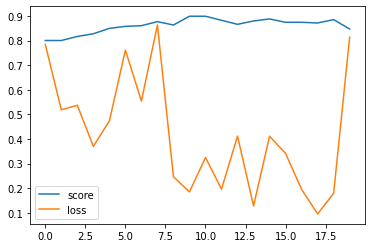

In [9]:
train(efficient_net, train_set, test_set, label = MODEL, ax = plt.subplot())

In [10]:
submission = predict(efficient_net, test_raw)

if not DEBUG:
    submission.to_csv('./dataset/submission_{}.csv'.format(MODEL), index = False)

submission

100%|██████████| 1821/1821 [20:21<00:00,  1.49it/s]


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.009750,0.047512,0.940279,0.002459
1,Test_1,0.007526,0.126030,0.849131,0.017314
2,Test_2,0.012993,0.156468,0.811401,0.019138
3,Test_3,0.046129,0.053460,0.894425,0.005987
4,Test_4,0.005067,0.055575,0.936101,0.003257
...,...,...,...,...,...
1816,Test_1816,0.007419,0.090349,0.894717,0.007515
1817,Test_1817,0.018814,0.248996,0.681831,0.050359
1818,Test_1818,0.004277,0.043424,0.950170,0.002130
1819,Test_1819,0.033368,0.088123,0.871485,0.007024
